# Global Tweet Sentiment Analysis - Mood of the World

# Install Required Packages

In [1]:
!pip install tweepy textblob plotly pandas numpy wordcloud matplotlib seaborn python-dotenv --quiet
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


# Import Libraries

In [2]:
import tweepy
import pandas as pd
import numpy as np
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from datetime import datetime, timedelta
import re
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
pyo.init_notebook_mode(connected=True)

# Twitter API Configuration
## Note : get API from https://developer.twitter.com/


In [3]:
class TwitterConfig:
    def __init__(self):
        # Replace with your actual API credentials
        # Note : Use Paid Key if you use free key then the limit will be reached during data Preparation
        self.API_KEY = "YOUR_API_KEY"
        self.API_SECRET = "YOUR_API_SECRET"
        self.ACCESS_TOKEN = "YOUR_ACCESS_TOKEN"
        self.ACCESS_TOKEN_SECRET = "YOUR_ACCESS_TOKEN_SECRET"
        self.BEARER_TOKEN = "YOUR_BEARER_TOKEN"

    def get_api_v1(self):
        """Get Twitter API v1.1 client"""
        auth = tweepy.OAuthHandler(self.API_KEY, self.API_SECRET)
        auth.set_access_token(self.ACCESS_TOKEN, self.ACCESS_TOKEN_SECRET)
        return tweepy.API(auth, wait_on_rate_limit=True)

    def get_api_v2(self):
        """Get Twitter API v2 client"""
        return tweepy.Client(
            bearer_token=self.BEARER_TOKEN,
            consumer_key=self.API_KEY,
            consumer_secret=self.API_SECRET,
            access_token=self.ACCESS_TOKEN,
            access_token_secret=self.ACCESS_TOKEN_SECRET,
            wait_on_rate_limit=True
        )
config = TwitterConfig()

# Data Collection

In [4]:
class GlobalTweetCollector:
    def __init__(self, api_v1, api_v2):
        self.api_v1 = api_v1
        self.api_v2 = api_v2
        self.tweets_data = []

    def clean_tweet(self, text):
        """Clean tweet text for better sentiment analysis"""
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = ' '.join(text.split())
        return text.strip()

    def get_sentiment(self, text):
        """Analyze sentiment using TextBlob"""
        try:
            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            subjectivity = blob.sentiment.subjectivity
            if polarity > 0.1:
                sentiment = 'Positive'
            elif polarity < -0.1:
                sentiment = 'Negative'
            else:
                sentiment = 'Neutral'

            return {
                'sentiment': sentiment,
                'polarity': polarity,
                'subjectivity': subjectivity
            }
        except:
            return {
                'sentiment': 'Neutral',
                'polarity': 0.0,
                'subjectivity': 0.0
            }

    def collect_global_tweets(self, keywords=None, count=1000):
        """Collect tweets from around the world"""
        if keywords is None:
            keywords = [
                "good morning", "how are you", "feeling", "mood", "happy",
                "sad", "excited", "worried", "grateful", "blessed",
                "monday", "tuesday", "wednesday", "thursday", "friday",
                "weekend", "today", "life", "work", "family"
            ]

        print(f"Starting global tweet collection...")

        for keyword in keywords:
            try:
                print(f"Searching for: '{keyword}'")
                tweets = tweepy.Paginator(
                    self.api_v2.search_recent_tweets,
                    query=f"{keyword} -is:retweet lang:en",
                    tweet_fields=['created_at', 'author_id', 'public_metrics', 'geo'],
                    max_results=100,
                    limit=10
                ).flatten(limit=count // len(keywords))

                for tweet in tweets:
                    if tweet.text:
                        cleaned_text = self.clean_tweet(tweet.text)
                        if len(cleaned_text) > 10:
                            sentiment_data = self.get_sentiment(cleaned_text)

                            tweet_data = {
                                'id': tweet.id,
                                'text': cleaned_text,
                                'original_text': tweet.text,
                                'created_at': tweet.created_at,
                                'author_id': tweet.author_id,
                                'keyword': keyword,
                                'sentiment': sentiment_data['sentiment'],
                                'polarity': sentiment_data['polarity'],
                                'subjectivity': sentiment_data['subjectivity'],
                                'retweet_count': tweet.public_metrics['retweet_count'] if tweet.public_metrics else 0,
                                'like_count': tweet.public_metrics['like_count'] if tweet.public_metrics else 0,
                            }

                            self.tweets_data.append(tweet_data)

            except Exception as e:
                print(f"Error collecting tweets for '{keyword}': {str(e)}")
                continue

        print(f"Collected {len(self.tweets_data)} tweets total")
        return pd.DataFrame(self.tweets_data)

# Initialize APIs and Collect Data or Sample Data for Demonstration

In [5]:
try:
    api_v1 = config.get_api_v1()
    api_v2 = config.get_api_v2()

    print("Testing Twitter API connection...")
    me = api_v1.verify_credentials()
    if me:
        print(f"Connected as: @{me.screen_name}")
    else:
        print("API connection failed.")
    collector = GlobalTweetCollector(api_v1, api_v2)
    df_tweets = collector.collect_global_tweets(count=2000)

    if len(df_tweets) > 0:
        print(f"Dataset shape: {df_tweets.shape}")
        print("\n Dataset info:")
        print(df_tweets.info())
        print(f"\n Sentiment distribution:")
        print(df_tweets['sentiment'].value_counts())
    else:
        print("No tweets collected. Check your API credentials.")

except Exception as e:
    print(f"Error: {str(e)}")

    print("\n Creating sample data for demonstration...")
    sample_data = {
        'text': [
            'Having a great day today!',
            'Feeling a bit down lately',
            'Just another normal Monday',
            'So excited for the weekend!',
            'Work is really stressing me out',
            'Grateful for my family and friends',
            'Weather is perfect today',
            'This week has been challenging',
            'Looking forward to vacation',
            'Love spending time with loved ones'
        ] * 50,
        'sentiment': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative'] * 100,
        'polarity': np.random.normal(0, 0.3, 500),
        'subjectivity': np.random.uniform(0, 1, 500),
        'created_at': pd.date_range(start='2024-01-01', periods=500, freq='H'),
        'keyword': np.random.choice(['mood', 'feeling', 'today', 'happy', 'work'], 500)
    }
    df_tweets = pd.DataFrame(sample_data)
    print(f"Sample dataset created with {len(df_tweets)} tweets")

Testing Twitter API connection...
Error: 401 Unauthorized
89 - Invalid or expired token.

 Creating sample data for demonstration...
Sample dataset created with 500 tweets


# Data Analysis

In [6]:
class SentimentAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.prepare_data()

    def prepare_data(self):
        """Prepare data for analysis"""
        if 'created_at' in self.df.columns:
            self.df['created_at'] = pd.to_datetime(self.df['created_at'])
            self.df['hour'] = self.df['created_at'].dt.hour
            self.df['day_of_week'] = self.df['created_at'].dt.day_name()
            self.df['date'] = self.df['created_at'].dt.date

    def get_sentiment_summary(self):
        """Get overall sentiment statistics"""
        total_tweets = len(self.df)
        sentiment_counts = self.df['sentiment'].value_counts()

        summary = {
            'total_tweets': total_tweets,
            'positive_pct': (sentiment_counts.get('Positive', 0) / total_tweets) * 100,
            'negative_pct': (sentiment_counts.get('Negative', 0) / total_tweets) * 100,
            'neutral_pct': (sentiment_counts.get('Neutral', 0) / total_tweets) * 100,
            'avg_polarity': self.df['polarity'].mean(),
            'avg_subjectivity': self.df['subjectivity'].mean()
        }

        return summary

    def get_hourly_sentiment(self):
        """Analyze sentiment by hour of day"""
        hourly_sentiment = self.df.groupby(['hour', 'sentiment']).size().unstack(fill_value=0)
        hourly_polarity = self.df.groupby('hour')['polarity'].mean()

        return hourly_sentiment, hourly_polarity

    def get_daily_sentiment(self):
        """Analyze sentiment by day of week"""
        daily_sentiment = self.df.groupby(['day_of_week', 'sentiment']).size().unstack(fill_value=0)
        daily_polarity = self.df.groupby('day_of_week')['polarity'].mean()

        return daily_sentiment, daily_polarity

    def get_keyword_sentiment(self):
        """Analyze sentiment by keyword"""
        if 'keyword' in self.df.columns:
            keyword_sentiment = self.df.groupby(['keyword', 'sentiment']).size().unstack(fill_value=0)
            keyword_polarity = self.df.groupby('keyword')['polarity'].mean().sort_values(ascending=False)
            return keyword_sentiment, keyword_polarity
        return None, None

analyzer = SentimentAnalyzer(df_tweets)
summary = analyzer.get_sentiment_summary()

print("Mood of the World SUMMARY")
print("=" * 40)
print(f"Total Tweets Analyzed: {summary['total_tweets']:,}")
print(f"Positive Sentiment: {summary['positive_pct']:.1f}%")
print(f"Negative Sentiment: {summary['negative_pct']:.1f}%")
print(f"Neutral Sentiment: {summary['neutral_pct']:.1f}%")
print(f"Average Polarity: {summary['avg_polarity']:.3f}")
print(f"Average Subjectivity: {summary['avg_subjectivity']:.3f}")

Mood of the World SUMMARY
Total Tweets Analyzed: 500
Positive Sentiment: 40.0%
Negative Sentiment: 40.0%
Neutral Sentiment: 20.0%
Average Polarity: -0.017
Average Subjectivity: 0.491


# Create Interactive Visualizations

In [7]:
class SentimentVisualizer:
    def __init__(self, df, analyzer):
        self.df = df
        self.analyzer = analyzer

    def create_sentiment_overview(self):
        """Create overview dashboard"""
        summary = self.analyzer.get_sentiment_summary()

        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Sentiment Distribution', 'Polarity Distribution',
                          'Subjectivity vs Polarity', 'Sentiment Over Time'),
            specs=[[{"type": "pie"}, {"type": "histogram"}],
                   [{"type": "scatter"}, {"type": "scatter"}]]
        )

        # Sentiment pie chart
        sentiment_counts = self.df['sentiment'].value_counts()
        colors = ['#2E86AB', '#A23B72', '#F18F01']
        fig.add_trace(
            go.Pie(labels=sentiment_counts.index, values=sentiment_counts.values,
                   marker_colors=colors, name="Sentiment"),
            row=1, col=1
        )

        # Polarity histogram
        fig.add_trace(
            go.Histogram(x=self.df['polarity'], nbinsx=30, name="Polarity",
                        marker_color='#2E86AB', opacity=0.7),
            row=1, col=2
        )

        # Subjectivity vs Polarity scatter
        fig.add_trace(
            go.Scatter(x=self.df['subjectivity'], y=self.df['polarity'],
                      mode='markers', name="Tweets",
                      marker=dict(color=self.df['polarity'], colorscale='RdYlBu',
                                size=5, opacity=0.6),
                      text=self.df['text'].str[:100] + '...',
                      hovertemplate='<b>Subjectivity:</b> %{x:.2f}<br>' +
                                  '<b>Polarity:</b> %{y:.2f}<br>' +
                                  '<b>Text:</b> %{text}<extra></extra>'),
            row=2, col=1
        )

        # Sentiment over time (if date available)
        if 'created_at' in self.df.columns:
            hourly_data = self.df.groupby([self.df['created_at'].dt.hour, 'sentiment']).size().unstack(fill_value=0)

            for sentiment in ['Positive', 'Negative', 'Neutral']:
                if sentiment in hourly_data.columns:
                    fig.add_trace(
                        go.Scatter(x=hourly_data.index, y=hourly_data[sentiment],
                                 mode='lines+markers', name=f"{sentiment} Tweets",
                                 line=dict(width=2)),
                        row=2, col=2
                    )

        fig.update_layout(
            title_text="🌍 Global Mood Analysis Dashboard",
            title_x=0.5,
            height=800,
            showlegend=True,
            template="plotly_white"
        )

        return fig

    def create_hourly_heatmap(self):
        """Create hourly sentiment heatmap"""
        hourly_sentiment, hourly_polarity = self.analyzer.get_hourly_sentiment()

        # Calculate percentages
        hourly_pct = hourly_sentiment.div(hourly_sentiment.sum(axis=1), axis=0) * 100

        fig = go.Figure()

        # Add heatmap for each sentiment
        sentiments = ['Positive', 'Neutral', 'Negative']
        colors = ['Greens', 'Greys', 'Reds']

        for i, (sentiment, colorscale) in enumerate(zip(sentiments, colors)):
            if sentiment in hourly_pct.columns:
                visible = True if i == 0 else False
                fig.add_trace(
                    go.Heatmap(
                        z=[hourly_pct[sentiment].values],
                        x=hourly_pct.index,
                        y=[sentiment],
                        colorscale=colorscale,
                        name=sentiment,
                        visible=visible,
                        hovertemplate=f'<b>Hour:</b> %{{x}}<br><b>{sentiment}:</b> %{{z:.1f}}%<extra></extra>'
                    )
                )

        # Add buttons for different sentiments
        buttons = []
        for i, sentiment in enumerate(sentiments):
            if sentiment in hourly_pct.columns:
                visibility = [False] * len(sentiments)
                visibility[i] = True
                buttons.append(
                    dict(
                        method="update",
                        args=[{"visible": visibility}],
                        label=sentiment
                    )
                )

        fig.update_layout(
            title="📅 Hourly Sentiment Distribution",
            xaxis_title="Hour of Day",
            updatemenus=[
                dict(
                    type="buttons",
                    direction="right",
                    x=0.7,
                    y=1.15,
                    buttons=buttons
                )
            ],
            height=400,
            template="plotly_white"
        )

        return fig

    def create_world_mood_gauge(self):
        """Create a mood gauge for the world"""
        summary = self.analyzer.get_sentiment_summary()
        avg_polarity = summary['avg_polarity']

        # Convert polarity to 0-100 scale
        mood_score = ((avg_polarity + 1) / 2) * 100

        fig = go.Figure(go.Indicator(
            mode = "gauge+number+delta",
            value = mood_score,
            domain = {'x': [0, 1], 'y': [0, 1]},
            title = {'text': "🌍 World Mood Score"},
            delta = {'reference': 50},
            gauge = {
                'axis': {'range': [None, 100]},
                'bar': {'color': "darkblue"},
                'steps': [
                    {'range': [0, 25], 'color': "lightgray"},
                    {'range': [25, 50], 'color': "gray"},
                    {'range': [50, 75], 'color': "lightgreen"},
                    {'range': [75, 100], 'color': "green"}
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 90
                }
            }
        ))

        fig.update_layout(
            height=400,
            template="plotly_white",
            annotations=[
                dict(
                    x=0.5, y=0.1,
                    text=f"Based on {summary['total_tweets']:,} tweets<br>" +
                         f"Avg Polarity: {avg_polarity:.3f}",
                    showarrow=False,
                    font=dict(size=12)
                )
            ]
        )

        return fig

    def create_keyword_sentiment_chart(self):
        """Create keyword sentiment analysis"""
        keyword_sentiment, keyword_polarity = self.analyzer.get_keyword_sentiment()

        if keyword_sentiment is not None:
            fig = px.bar(
                keyword_sentiment.reset_index(),
                x='keyword',
                y=['Positive', 'Neutral', 'Negative'],
                title="📝 Sentiment by Keyword",
                labels={'value': 'Number of Tweets', 'keyword': 'Keywords'},
                color_discrete_map={
                    'Positive': '#2E86AB',
                    'Neutral': '#A23B72',
                    'Negative': '#F18F01'
                }
            )

            fig.update_layout(
                height=500,
                template="plotly_white",
                xaxis_tickangle=-45
            )

            return fig
        return None

# Create visualizations
visualizer = SentimentVisualizer(df_tweets, analyzer)
print("Interactive Visualizations")

# Overview Dashboard
overview_fig = visualizer.create_sentiment_overview()
overview_fig.show()

# Hourly Heatmap
hourly_fig = visualizer.create_hourly_heatmap()
hourly_fig.show()

# World Mood Gauge
gauge_fig = visualizer.create_world_mood_gauge()
gauge_fig.show()

# Keyword Sentiment Analysis
keyword_fig = visualizer.create_keyword_sentiment_chart()
if keyword_fig:
    keyword_fig.show()

Interactive Visualizations


# Word Cloud Generation

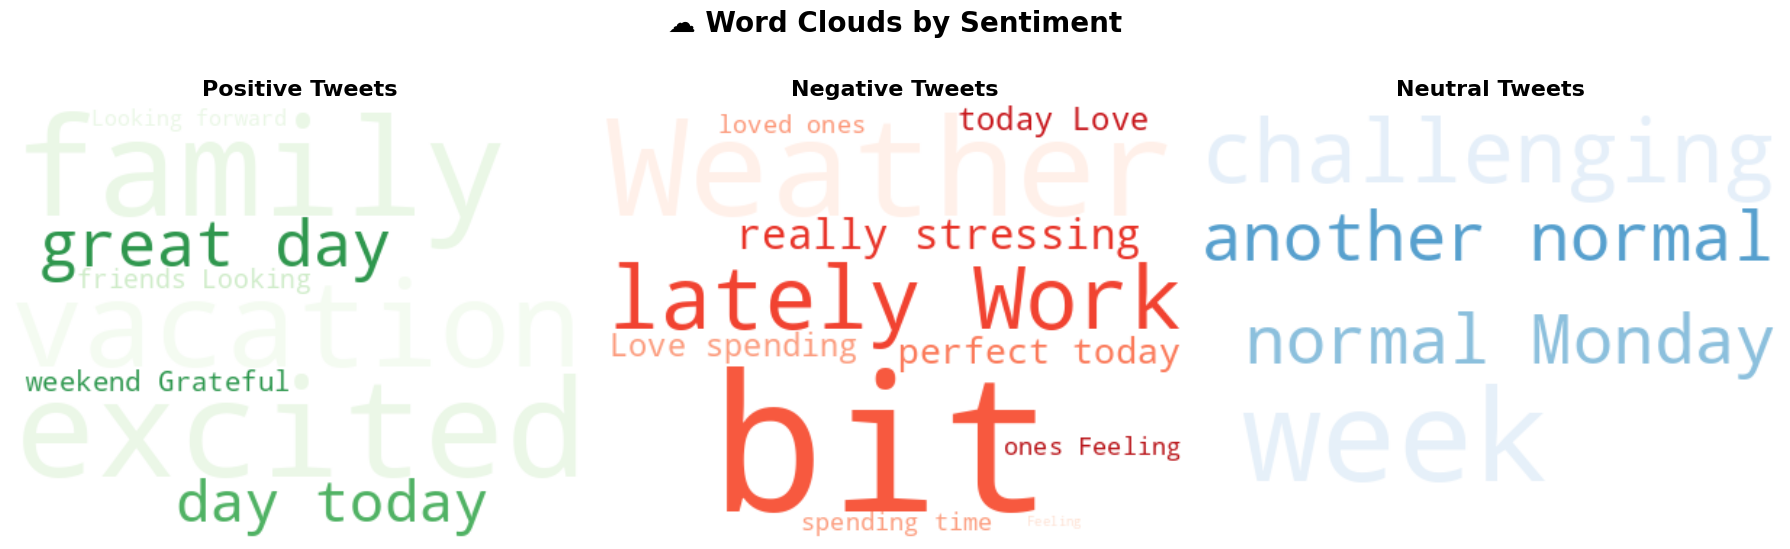

In [8]:
def create_sentiment_wordclouds(df):
    """Create word clouds for different sentiments"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sentiments = ['Positive', 'Negative', 'Neutral']
    colors = ['Greens', 'Reds', 'Blues']

    for i, (sentiment, colormap) in enumerate(zip(sentiments, colors)):
        sentiment_tweets = df[df['sentiment'] == sentiment]['text']

        if len(sentiment_tweets) > 0:
            text = ' '.join(sentiment_tweets.astype(str))

            wordcloud = WordCloud(
                width=400, height=300,
                background_color='white',
                colormap=colormap,
                max_words=100,
                relative_scaling=0.5,
                random_state=42
            ).generate(text)

            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{sentiment} Tweets', fontsize=16, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'No {sentiment} tweets',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{sentiment} Tweets', fontsize=16, fontweight='bold')
            axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('☁️ Word Clouds by Sentiment', fontsize=20, fontweight='bold', y=1.02)
    plt.show()

# Generate word clouds
create_sentiment_wordclouds(df_tweets)

# Advanced Time Series Analysis

In [9]:
def create_time_series_analysis(df):
    """Create detailed time series analysis"""
    if 'created_at' not in df.columns:
        print("No timestamp data available")
        return
    df_hourly = df.set_index('created_at').resample('H').agg({
        'polarity': ['mean', 'std', 'count'],
        'subjectivity': 'mean'
    }).round(3)

    df_hourly.columns = ['polarity_mean', 'polarity_std', 'tweet_count', 'subjectivity_mean']
    df_hourly = df_hourly.dropna()

    if len(df_hourly) > 0:
        fig = make_subplots(
            rows=3, cols=1,
            subplot_titles=('Average Polarity Over Time', 'Tweet Volume', 'Subjectivity Levels'),
            vertical_spacing=0.08
        )

        fig.add_trace(
            go.Scatter(
                x=df_hourly.index,
                y=df_hourly['polarity_mean'],
                mode='lines+markers',
                name='Avg Polarity',
                line=dict(color='#2E86AB', width=2),
                fill='tonexty'
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Bar(
                x=df_hourly.index,
                y=df_hourly['tweet_count'],
                name='Tweet Count',
                marker_color='#A23B72',
                opacity=0.7
            ),
            row=2, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=df_hourly.index,
                y=df_hourly['subjectivity_mean'],
                mode='lines+markers',
                name='Avg Subjectivity',
                line=dict(color='#F18F01', width=2)
            ),
            row=3, col=1
        )

        fig.update_layout(
            title_text="📈 Advanced Time Series Analysis",
            height=900,
            showlegend=False,
            template="plotly_white"
        )

        fig.show()

create_time_series_analysis(df_tweets)

# Export Results and Text Report

In [10]:
def export_results(df, summary):
    """Export analysis results"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    filename_data = f"global_sentiment_data_{timestamp}.csv"
    df.to_csv(filename_data, index=False)
    print(f"Dataset exported: {filename_data}")

    filename_summary = f"sentiment_summary_{timestamp}.json"
    with open(filename_summary, 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    print(f"Summary exported: {filename_summary}")

    report = f"""
Mood of the World ANALYSIS REPORT
Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
{'='*50}

OVERVIEW
Total Tweets Analyzed: {summary['total_tweets']:,}
Analysis Period: {df['created_at'].min()} to {df['created_at'].max()}

SENTIMENT BREAKDOWN
Positive: {summary['positive_pct']:.1f}%
Negative: {summary['negative_pct']:.1f}%
Neutral: {summary['neutral_pct']:.1f}%

EMOTIONAL METRICS
Average Polarity: {summary['avg_polarity']:.3f} (Range: -1 to +1)
Average Subjectivity: {summary['avg_subjectivity']:.3f} (Range: 0 to 1)

WORLD MOOD TEMPERATURE
{((summary['avg_polarity'] + 1) / 2) * 100:.1f}/100

INSIGHTS
- The world is feeling {'more positive' if summary['avg_polarity'] > 0 else 'more negative' if summary['avg_polarity'] < 0 else 'neutral'} overall
- Emotional expression is {'highly subjective' if summary['avg_subjectivity'] > 0.6 else 'moderately subjective' if summary['avg_subjectivity'] > 0.3 else 'relatively objective'}
- Most common sentiment: {df['sentiment'].mode().iloc[0]}
    """

    filename_report = f"mood_report_{timestamp}.txt"
    with open(filename_report, 'w') as f:
        f.write(report)
    print(f"Report exported: {filename_report}")

    print(report)

export_results(df_tweets, summary)

Dataset exported: global_sentiment_data_20250706_013159.csv
Summary exported: sentiment_summary_20250706_013159.json
Report exported: mood_report_20250706_013159.txt

Mood of the World ANALYSIS REPORT
Generated: 2025-07-06 01:32:00

OVERVIEW
Total Tweets Analyzed: 500
Analysis Period: 2024-01-01 00:00:00 to 2024-01-21 19:00:00

SENTIMENT BREAKDOWN
Positive: 40.0%
Negative: 40.0%
Neutral: 20.0%

EMOTIONAL METRICS
Average Polarity: -0.017 (Range: -1 to +1)
Average Subjectivity: 0.491 (Range: 0 to 1)

WORLD MOOD TEMPERATURE
49.2/100

INSIGHTS
- The world is feeling more negative overall
- Emotional expression is moderately subjective
- Most common sentiment: Negative
    


# In this version the data fetching is working properly but due rate limit the data collection is stoped in middle
## Step to solve this error
* use paid API for the result
* as the data collection is interupted , there is no proper sample data that's why graph is not displaying properly
* a proper Mood of the world with the free API will be built on upcoming commit { code2.ipynb }